# Traffic Sign Recognition

The Dataset: 

# Initialization

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [36]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [37]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [38]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )
        

## MLOps

Weights an Biases init

In [39]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [69]:
#Generic dataset parameters
img_width, img_height = 48, 48
batch_size = 128
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Simple Keras based data augmentation

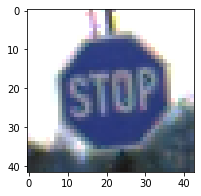

In [70]:
# loading an image sample
img = get_input_img(sign_class=14, img_height=img_height, img_width=img_width, index=31, dataset='Train')

def plot_augmented_samples (batch):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    # generate batch of images
    for i in range(3):
	    # convert to unsigned integers
	    image = next(aug_iter)[0].astype('uint8')
	    # plot image
	    ax[i].imshow(image)
	    ax[i].axis('off')
    

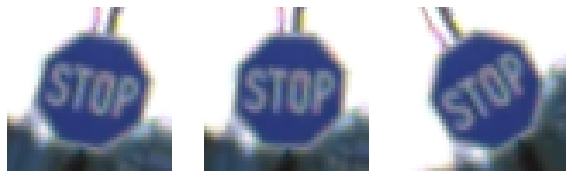

In [71]:
# image rotation
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

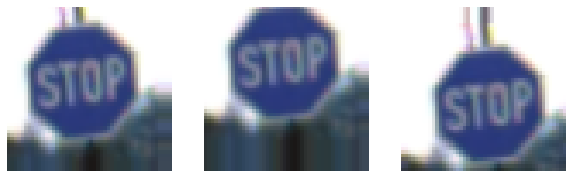

In [72]:
# height and width of the image
datagen = ImageDataGenerator(width_shift_range=.2, 
        height_shift_range=.2,
        fill_mode='nearest'
        )
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

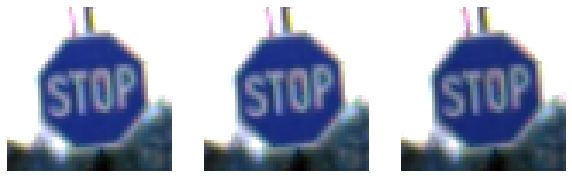

In [73]:
# brightness
datagen = ImageDataGenerator(brightness_range=[1,1.2])
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

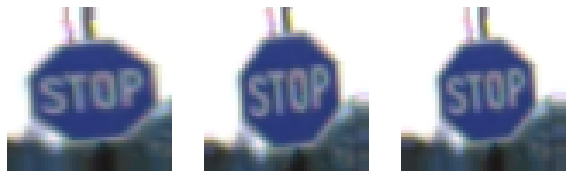

In [74]:
# zoom
datagen = ImageDataGenerator(zoom_range=0.2)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

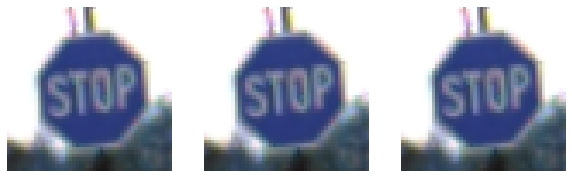

In [75]:
# ZCA whitening
datagen = ImageDataGenerator(zca_whitening=True)  # zoom
# iterator
aug_iter = datagen.flow(img, batch_size=1)
plot_augmented_samples(aug_iter)

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


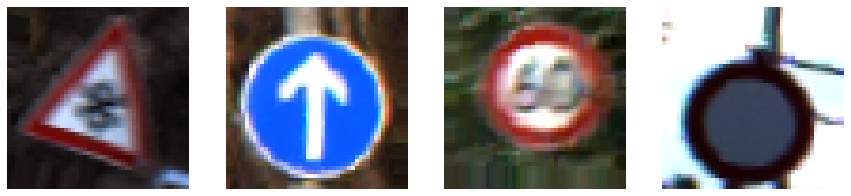

In [76]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=20,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2],
    # zoom
    #zoom_range=0.2,
    #zca_whitening
    zca_whitening=True
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


In [77]:
# training dataset
# With Keras data augmentation

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
        #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, 
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=20,
        # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
        width_shift_range=.1, 
        height_shift_range=.1,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        #zoom_range=0.2,
        #zca_whitening
        zca_whitening=True,
        rescale=1./255)
        
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [78]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [79]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


In [80]:
print('Batches train=%d, test=%d' % (len(train_generator), len(test_generator)))

Batches train=215, test=99


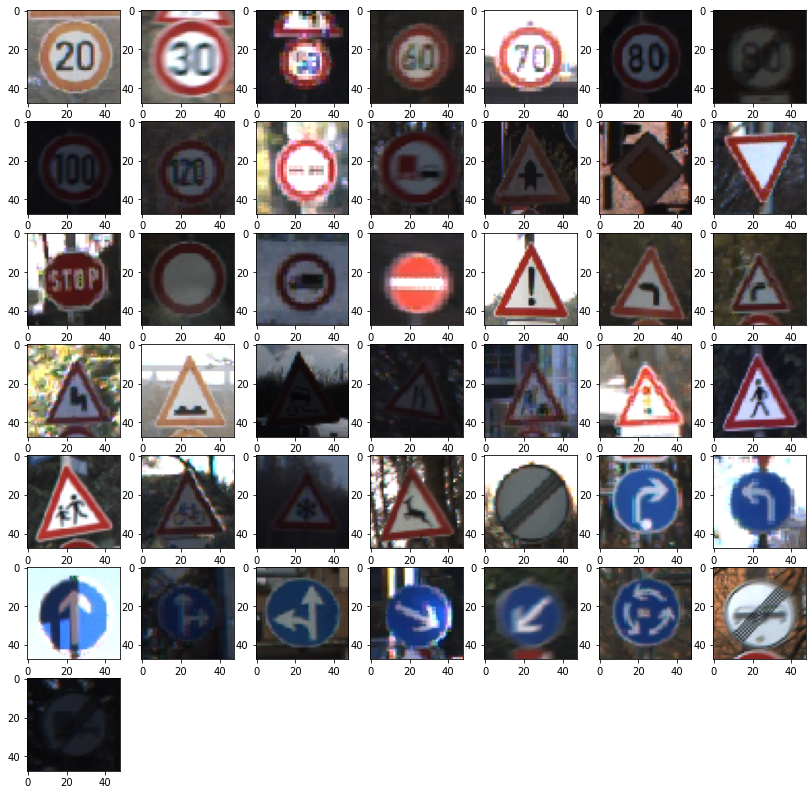

In [81]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [82]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

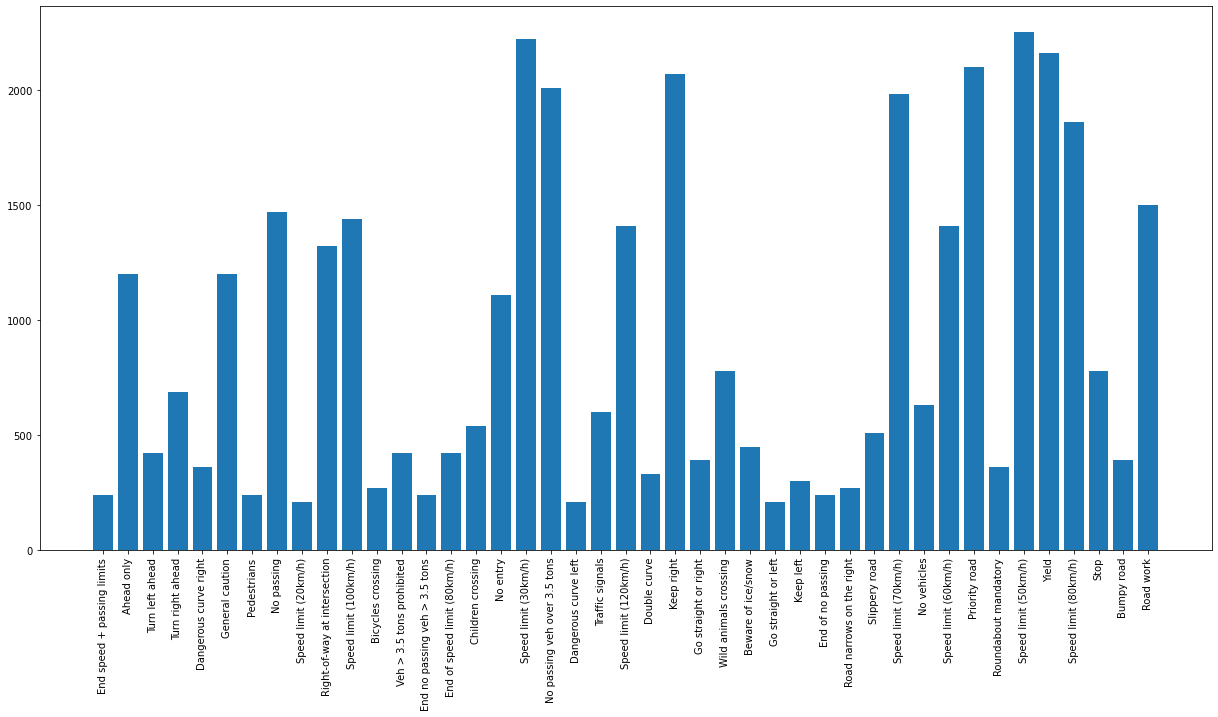

In [83]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [87]:
# Calculating the weights to compensate for the class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [88]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [89]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

2022-01-07 23:36:20.448665: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training And Evaluating The Model

In [90]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)

In [91]:
from tensorflow.keras import optimizers 

baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1])

In [92]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [93]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [94]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline_b256_e100_DA' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


InvalidArgumentError:  Input to reshape is a tensor with 409600 values, but the requested shape requires a multiple of 1152
	 [[node sequential/flatten/Reshape
 (defined at /usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/layers/core/flatten.py:96)
]] [Op:__inference_train_function_929]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/flatten/Reshape:
In[0] sequential/max_pooling2d_1/MaxPool (defined at /usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/layers/pooling.py:357)	
In[1] sequential/flatten/Const (defined at /usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/layers/core/flatten.py:91)

Operation defined at: (most recent call last)
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/3627286818.py", line 6, in <module>
>>>     history_baseline = baseline_model.fit(
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 167, in new_v2
>>>     return old_v2(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras/layers/core/flatten.py", line 96, in call
>>>     return tf.reshape(inputs, flattened_shape)
>>> 

/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


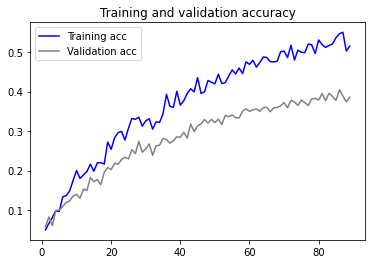

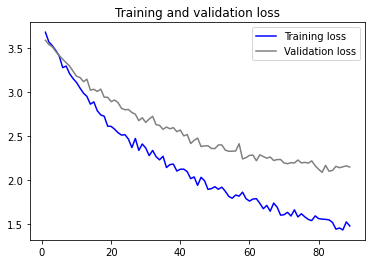

In [ ]:
plot_results(history_baseline)

Confusion matrix, without normalization
[[ 0  3  3 ...  1  0  1]
 [ 0 34 40 ... 15 17 15]
 [ 0 28 37 ... 18 21  9]
 ...
 [ 0 26 30 ... 10 12 10]
 [ 0 20 18 ... 14  9 15]
 [ 0 19 31 ... 14 15 17]]


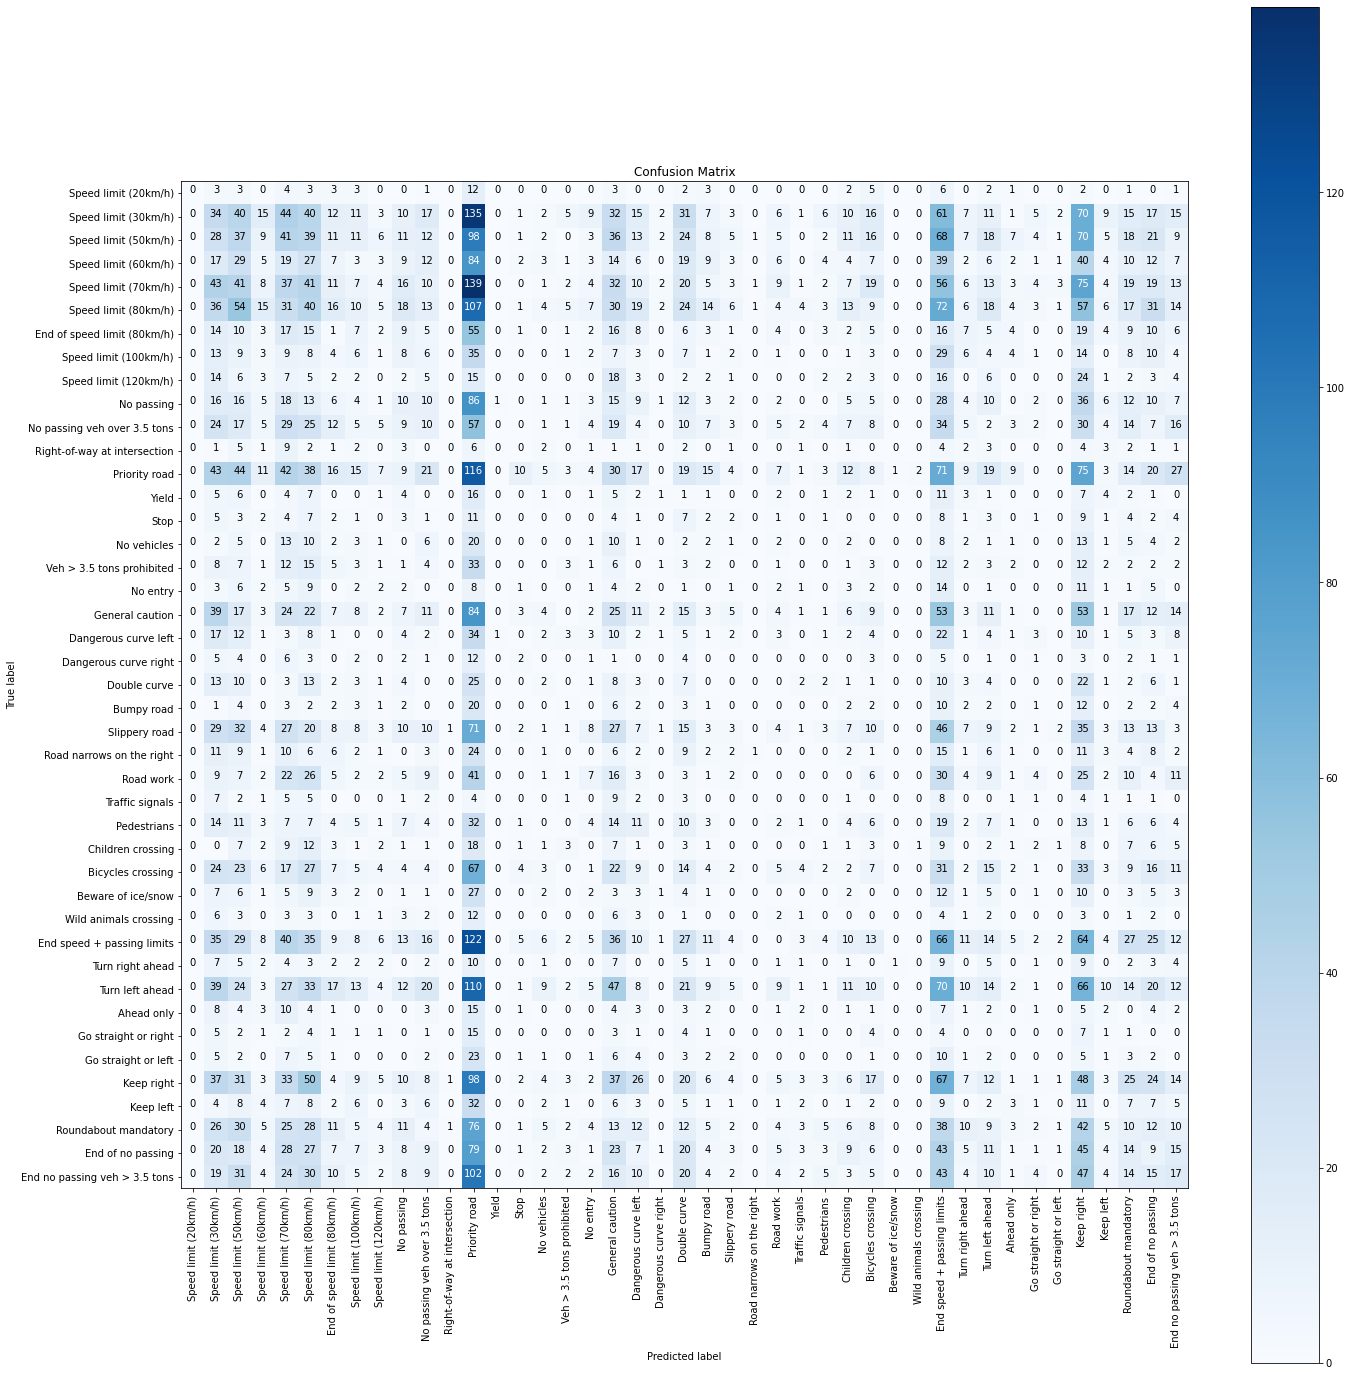

In [ ]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

Shape before entering the conv layer: (1, 32, 32, 3)


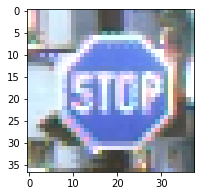

In [ ]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 15, 15, 32)
(1, 13, 13, 32)
(1, 6, 6, 32)
(1, 1152)
(1, 128)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_1830/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


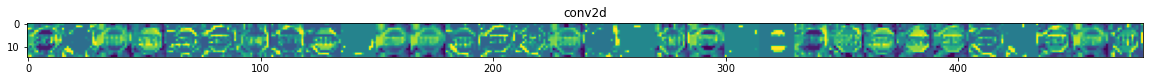

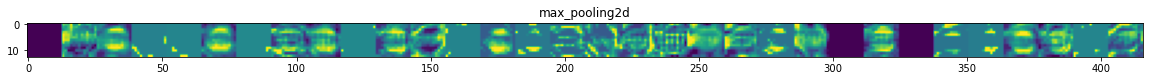

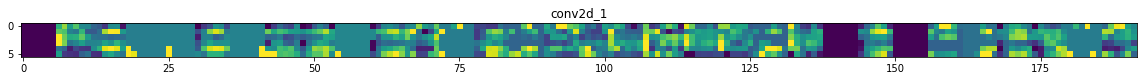

In [ ]:
plot_feature_maps(baseline_model, img)

## 7 layer model

Refference: Masci, et al "A committee of neural networks for traffic sign classification" [1]

In [95]:
masci_model = Sequential()
# Refference: DLNN lecture week 6
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (4, 4), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
masci_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
masci_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
masci_model.add(Flatten())
# MLP - hidden layer
masci_model.add(Dense(units=200, activation=relu))
# MLP - output layer
masci_model.add(Dense(units=43, activation=softmax))

# Check built model:
masci_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 32)        

In [96]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)
masci_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1])

In [97]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 100
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [98]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 8
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [99]:
# MLOps init and callback
wandb.init(name='CNN_TS_masci_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_masci_model = masci_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
5/5 [==============================] - 15s 3s/step - loss: 3.7077 - acc: 0.0562 - f1_score: 0.0078 - val_loss: 3.5715 - val_acc: 0.0695 - val_f1_score: 0.0072
Epoch 2/100
5/5 [==============================] - 13s 3s/step - loss: 3.5870 - acc: 0.0656 - f1_score: 0.0079 - val_loss: 3.5170 - val_acc: 0.0551 - val_f1_score: 0.0024
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 3.5151 - acc: 0.0828 - f1_score: 0.0104 - val_loss: 3.4971 - val_acc: 0.0766 - val_f1_score: 0.0096
Epoch 4/100
5/5 [==============================] - 12s 3s/step - loss: 3.4821 - acc: 0.0969 - f1_score: 0.0219 - val_loss: 3.4436 - val_acc: 0.1148 - val_f1_score: 0.0218
Epoch 5/100
5/5 [==============================] - 17s 4s/step - loss: 3.4310 - acc: 0.1156 - f1_score: 0.0243 - val_loss: 3.4069 - val_acc: 0.1129 - val_f1_score: 0.0247
Epoch 6/100
5/5 [==============================] - 14s 3s/step - loss: 3.4199 - acc: 0.1297 - f1_score: 0.0342 - val_loss: 3.3345 - val_acc: 0.13

acc,▁▁▂▂▂▃▃▃▃▄▄▅▄▅▅▅▅▆▆▅▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇████
val_loss,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
acc,0.77656
best_epoch,74
best_val_loss,1.29663
epoch,82
loss,0.76441


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


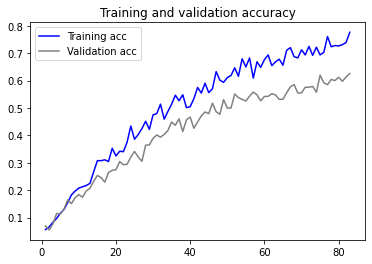

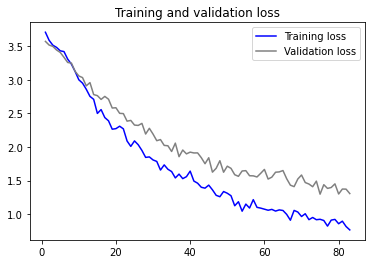

In [100]:
plot_results(history_masci_model)

Confusion matrix, without normalization
[[ 0  2  3 ...  4  2  2]
 [ 0 42 42 ... 26 44 20]
 [ 0 45 41 ... 10 36 33]
 ...
 [ 0 37 23 ... 15 37 11]
 [ 0 32 25 ... 14 26 16]
 [ 1 36 24 ... 18 24  7]]


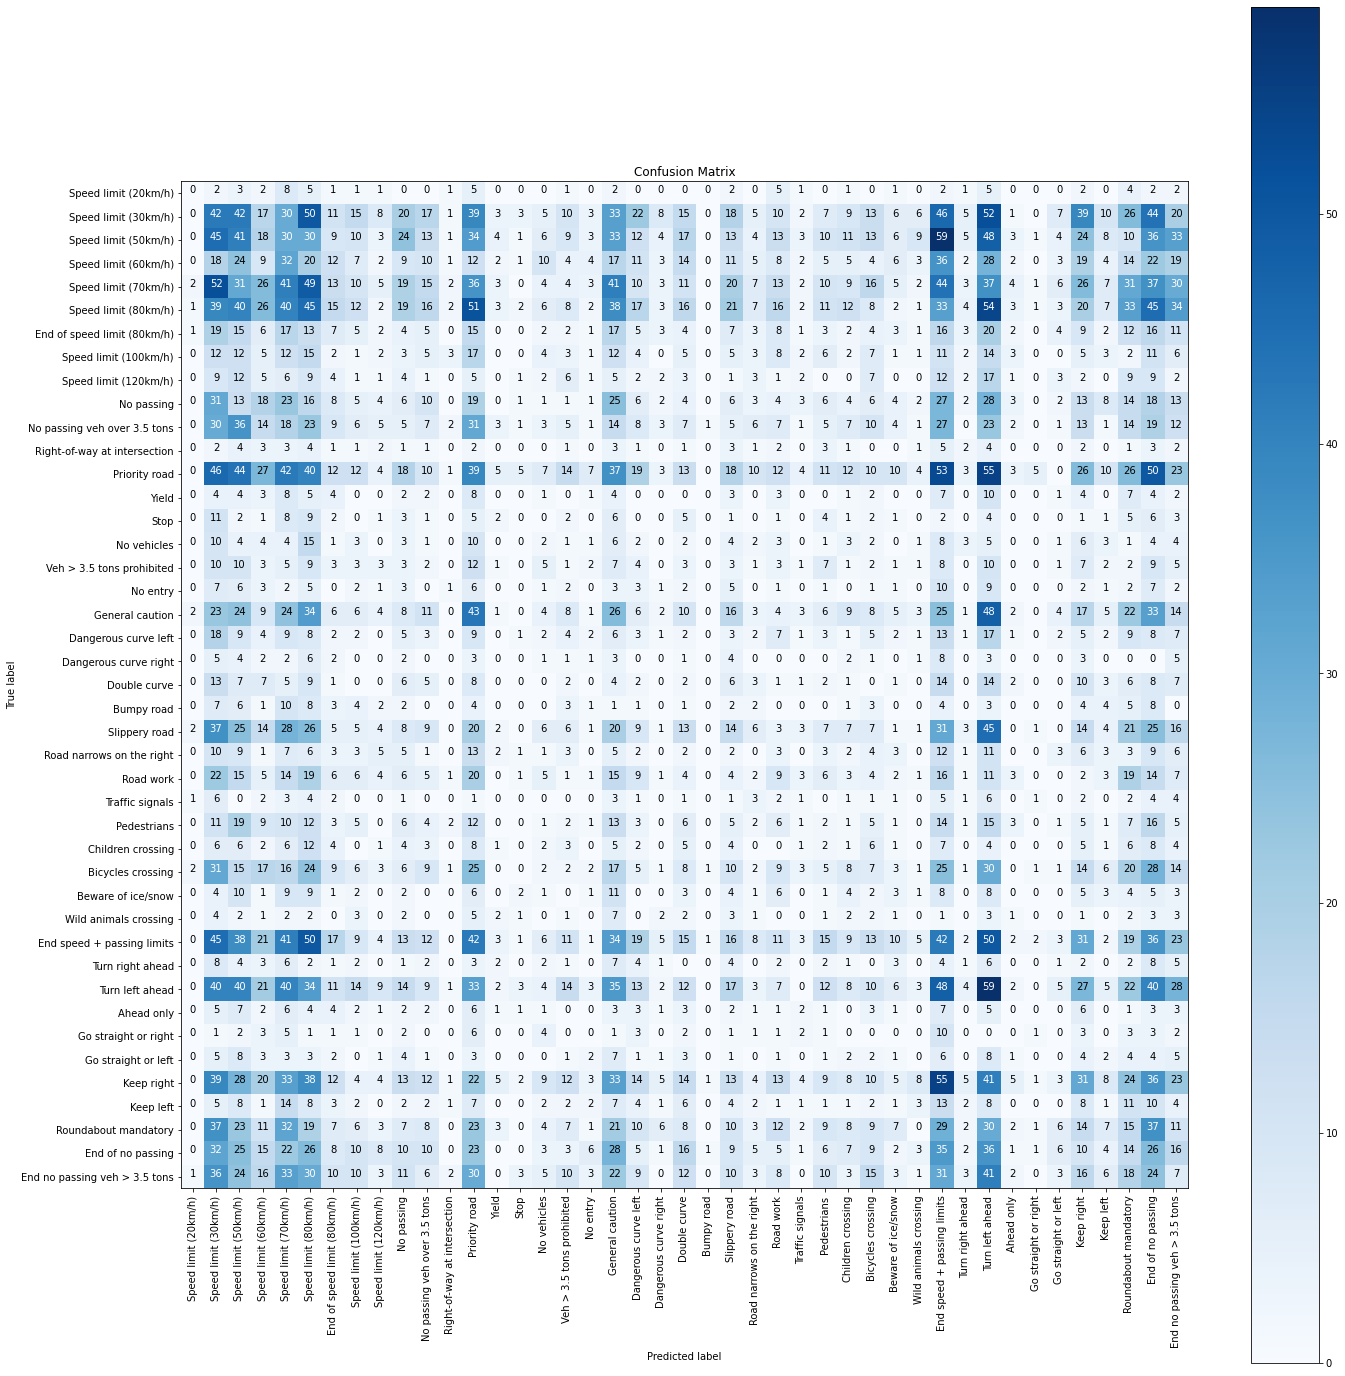

In [101]:
# predictions on Test data

Y_pred = masci_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [102]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        12
         Speed limit (30km/h)       0.06      0.05      0.05       839
         Speed limit (50km/h)       0.06      0.06      0.06       701
         Speed limit (60km/h)       0.02      0.02      0.02       381
         Speed limit (70km/h)       0.06      0.06      0.06       709
         Speed limit (80km/h)       0.06      0.06      0.06       756
  End of speed limit (80km/h)       0.03      0.03      0.03       237
        Speed limit (100km/h)       0.00      0.01      0.00       196
        Speed limit (120km/h)       0.01      0.01      0.01       102
                   No passing       0.02      0.02      0.02       288
 No passing veh over 3.5 tons       0.02      0.03      0.02       230
 Right-of-way at intersection       0.00      0.00      0.00        24
                Priority road       0.05      0.05      0.05       721
     

Shape before entering the conv layer: (1, 48, 48, 3)


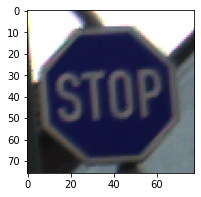

In [103]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 23, 23, 32)
(1, 20, 20, 32)
(1, 10, 10, 32)
(1, 8, 8, 32)
(1, 4, 4, 32)
(1, 512)
(1, 200)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


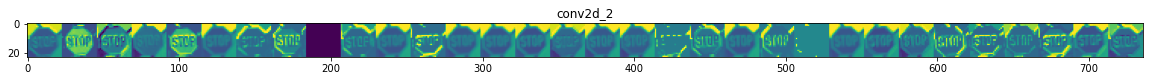

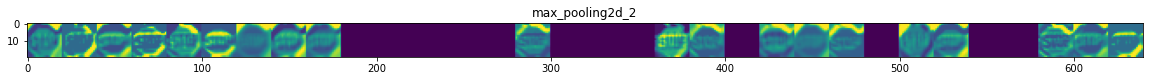

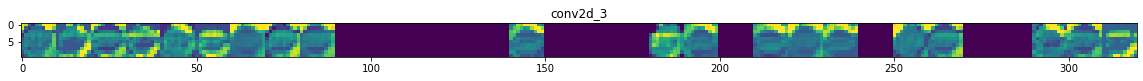

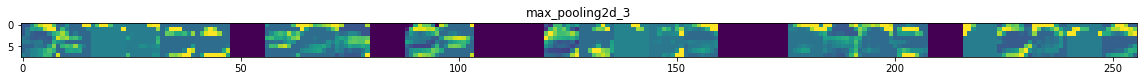

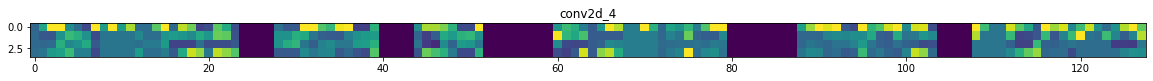

In [104]:
plot_feature_maps(masci_model, img)


## Small Scale Model

Refference: Chaudhari (et, al) "Traffic Sign Recognition Using Small-Scale Convolutional Neural Network"

In [127]:
lwm_model = Sequential()
# MLP - input layer
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(img_width, img_height, 3)))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
lwm_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
lwm_model.add(MaxPooling2D(pool_size=(2, 2)))
lwm_model.add(Dropout(0.25))
# MLP layer
lwm_model.add(Flatten())
lwm_model.add(Dense(units=256, activation=relu))
lwm_model.add(Dropout(0.25))
lwm_model.add(Dense(units=43, activation=softmax))


# Check built model:
lwm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                 

In [129]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

mlops_config['steps_per_epoch'] = 10
mlops_config['epochs'] = 1000
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [130]:
# adding f1-score
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average=None)

In [131]:
from tensorflow.keras import optimizers 

lwm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1 ])

In [132]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 10
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [133]:
# MLOps init and callback
wandb.init(name='CNN_TS_lwm_b256_e100' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_lwm_model = lwm_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/Caskroom/miniforge/base/envs/ims-dlnn/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/1000
10/10 [==============================] - 19s 2s/step - loss: 3.5986 - acc: 0.0680 - f1_score: 0.0149 - val_loss: 3.5447 - val_acc: 0.1082 - val_f1_score: 0.0121
Epoch 2/1000
10/10 [==============================] - 16s 2s/step - loss: 3.4603 - acc: 0.0906 - f1_score: 0.0207 - val_loss: 3.3670 - val_acc: 0.1117 - val_f1_score: 0.0162
Epoch 3/1000
10/10 [==============================] - 15s 2s/step - loss: 3.2926 - acc: 0.1234 - f1_score: 0.0333 - val_loss: 3.3008 - val_acc: 0.1180 - val_f1_score: 0.0347
Epoch 4/1000
10/10 [==============================] - 15s 2s/step - loss: 3.0798 - acc: 0.1758 - f1_score: 0.0633 - val_loss: 3.1074 - val_acc: 0.1770 - val_f1_score: 0.0613
Epoch 5/1000
10/10 [==============================] - 14s 1s/step - loss: 2.9809 - acc: 0.1883 - f1_score: 0.0768 - val_loss: 2.9339 - val_acc: 0.2410 - val_f1_score: 0.0934
Epoch 6/1000
10/10 [==============================] - 15s 2s/step - loss: 2.7530 - acc: 0.2289 - f1_score: 0.1027 - val_loss: 2.74

acc,▁▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▁▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.87266
best_epoch,90
best_val_loss,0.76114
epoch,100
loss,0.40117


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')


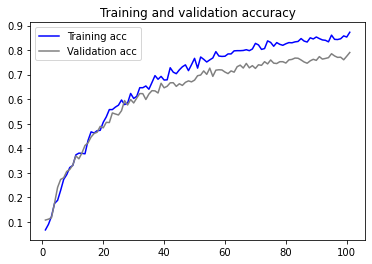

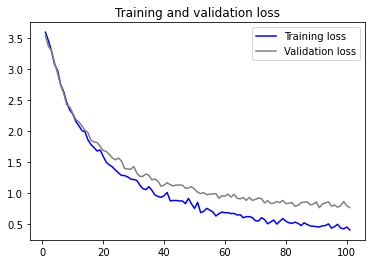

In [134]:
plot_results(history_lwm_model)

Confusion matrix, without normalization
[[ 0  5  3 ...  4  2  1]
 [ 0 42 27 ... 25 25 33]
 [ 0 35 34 ... 24 23 32]
 ...
 [ 0 23 24 ... 17 18 19]
 [ 0 21 24 ... 22 18 10]
 [ 0 25 30 ... 19 20 21]]


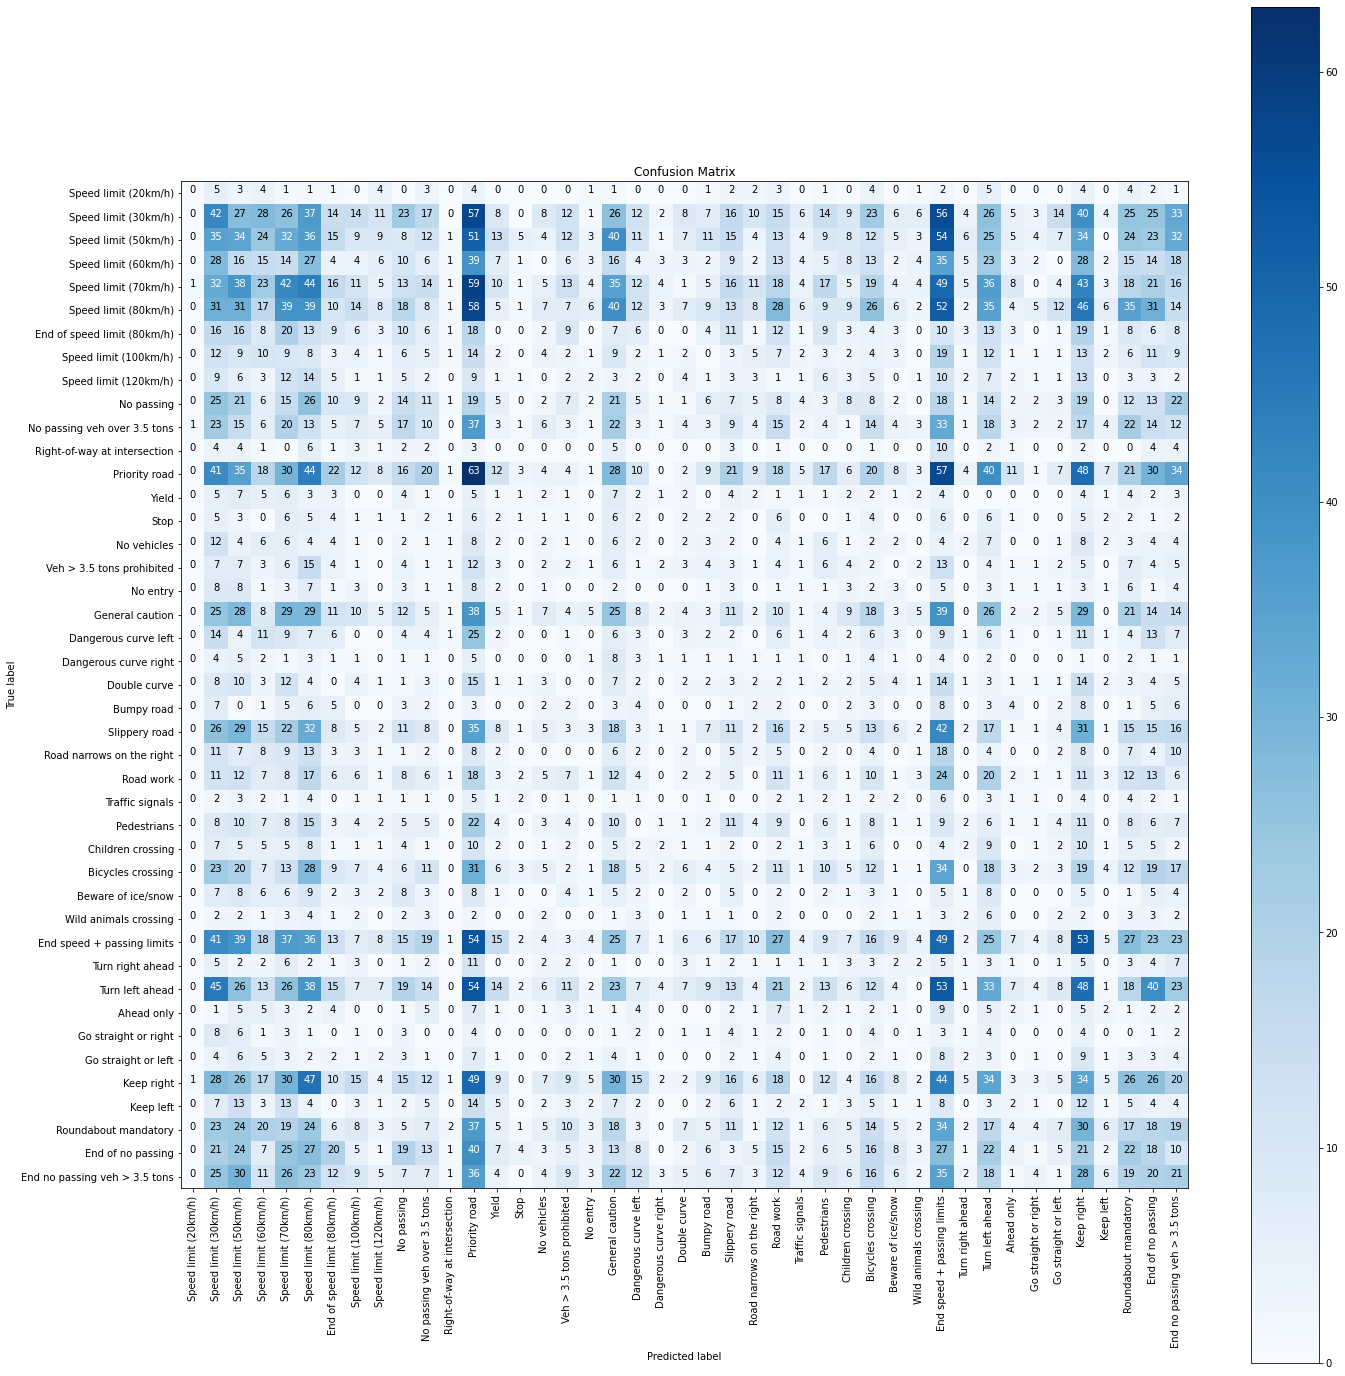

In [135]:
# predictions on Test data

Y_pred = lwm_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [136]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00         3
         Speed limit (30km/h)       0.06      0.06      0.06       703
         Speed limit (50km/h)       0.05      0.05      0.05       628
         Speed limit (60km/h)       0.04      0.04      0.04       363
         Speed limit (70km/h)       0.06      0.07      0.06       609
         Speed limit (80km/h)       0.05      0.05      0.05       727
  End of speed limit (80km/h)       0.03      0.03      0.03       270
        Speed limit (100km/h)       0.02      0.02      0.02       206
        Speed limit (120km/h)       0.01      0.01      0.01       116
                   No passing       0.04      0.04      0.04       313
 No passing veh over 3.5 tons       0.03      0.04      0.03       262
 Right-of-way at intersection       0.00      0.00      0.00        21
                Priority road       0.08      0.06      0.07      1008
     

Shape before entering the conv layer: (1, 48, 48, 3)


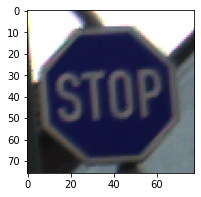

In [137]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 30, 'Test')
print ('Shape before entering the conv layer:', img.shape)

(1, 44, 44, 32)
(1, 22, 22, 32)
(1, 22, 22, 32)
(1, 20, 20, 32)
(1, 10, 10, 32)
(1, 10, 10, 32)
(1, 3200)
(1, 256)
(1, 256)
(1, 43)


/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_6073/1752642915.py:123: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


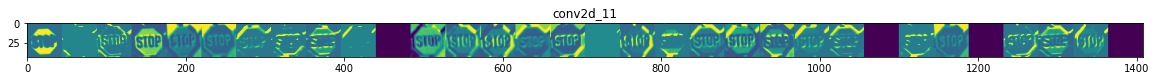

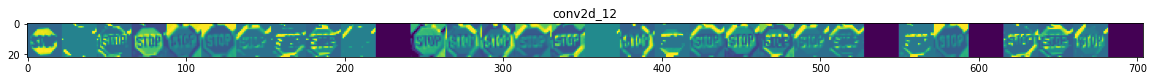

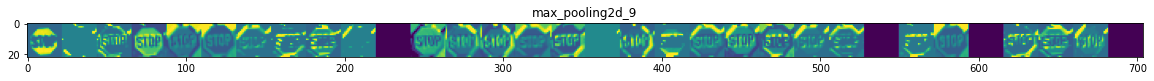

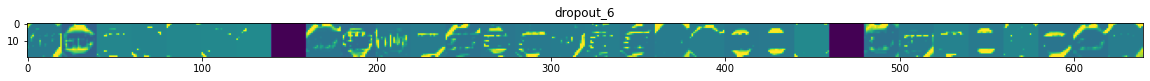

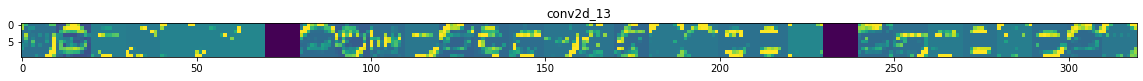

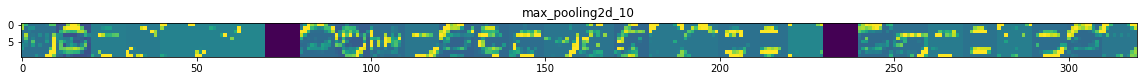

In [138]:
plot_feature_maps(lwm_model, img)

# Next Steps
- Plot the outputs of the several conv layers
- Check with different architectures:
  - See the used on the papers (masci done)
    - 2nd paper pending  - PA
    - consider a dropout layer with higher kernel values

- Check data augementation - PA
- Precision and recall metrics - JG
- Feature maps understanding  - AT / FB
- SHAP explainder - AT / FB

- Improve the acc/val loss graphs to plot multiple model curves

If time allows:
 - Check wandb sweep
 - consider different optimizers
 - consider different loss functions


# Batch Size and Epochs
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/


# 